In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import seaborn as sns

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
SOURCE_IMG_SIZE = 48
IMG_SIZE = 96

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry', 'disgusted', 'afraid']
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [4]:
df_fer = pd.read_csv('data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('data/ferplus2013.csv').iloc[:, 2:-3]
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 27307


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
images_raw = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
    images.append(transform(img))
    images_raw.append(img)
    labels.append(label_np[i])

In [6]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096
disgusted               66
afraid                 430


In [7]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images[:train_len]
train_labels = labels[:train_len]
test_images = images[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21845 (80.0%)
test length: 5462 (20.0%)


In [ ]:
print(train_images.shape)

In [8]:
BATCH_SIZE = 64


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [  2.899   3.07    7.906   9.129  13.231 474.891  63.874] 

get_loader():
  class weights: [  2.788   3.238   7.825   9.667  12.274 273.1    62.068] 



In [9]:
samples_train = [0]*NUM_CLASSES
samples_test = [0]*NUM_CLASSES

for idx, (images, labels) in enumerate(train_loader):
    for i in range(len(images)):
        samples_train[labels[i].item()] += 1

for idx, (images, labels) in enumerate(test_loader):
    for i in range(len(images)):
        samples_test[labels[i].item()] += 1


print('\033[4m{: <15} {: >15} {: >20}\033[0m'.format('class', '#samples (train)', '#samples (test)'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >15} {: >20}'.format(CLASSES[i], samples_train[i], samples_test[i]))

class           #samples (train)      #samples (test)
neutral                    3129                  763
happy                      3079                  797
surprised                  3172                  778
sad                        3028                  772
angry                      3159                  762
disgusted                  3082                  803
afraid                     3196                  787


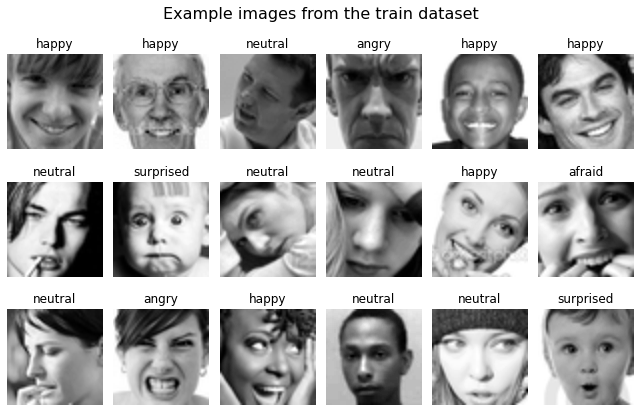

In [10]:
def imshow(dataset, title='', num_images=(3,6), rand=True):

    plt.figure(figsize=(num_images[1]*1.5, num_images[0]*2)); 
    plt.suptitle(title, fontsize=16)

    for i in range(num_images[0]):
        for j in range(num_images[1]):
            
            c = num_images[1]*i+(j+1)

            if not rand:
                idx = c
            else:
                idx = random.randint(0, len(dataset)-1)

            plt.subplot(num_images[0], num_images[1], c); plt.axis('off'); plt.title(CLASSES[dataset[idx][1]])
            plt.imshow(dataset[idx][0].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()


imshow(train_dataset, 'Example images from the train dataset')

## Filters

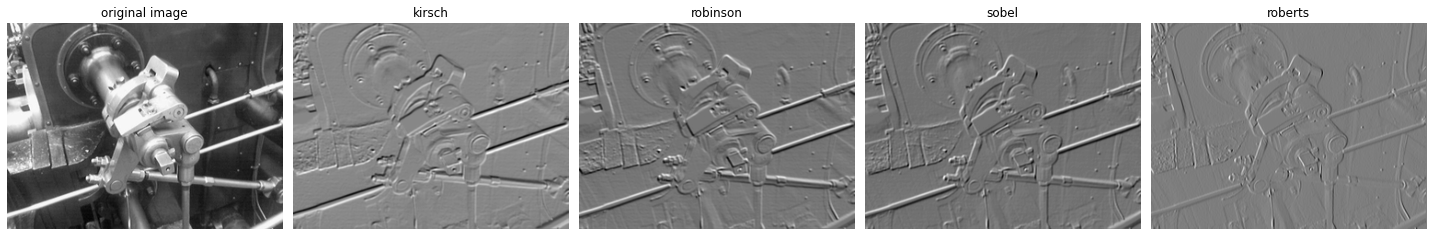

In [11]:
from scipy import ndimage

transform = transforms.Compose([
    transforms.ToTensor()
])
img = Image.open('data/steam_engine.PNG').convert('L')
img = transform(img).squeeze(0)



plt.figure(figsize=(20,20))

plt.subplot(1, 5, 1); plt.title('original image')
plt.axis('off')
plt.imshow(img, cmap='gray')



kirsch_compass_masks = [
    np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]]),   # north
    np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]]),   # north-east
    np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]]),   # east
    np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]]),   # south-east
    # np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]]),   # south
    # np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]]),   # south-west 
    # np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]]),   # west
    # np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]]),   # north-west
]

robinson_compass_masks = [
    np.array([[-1,-0,1],[-2,0,2],[-1,0,1]]),   # north
    np.array([[0,1,2],[-1,0,1],[-2,-1,0]]),   # north-east
    np.array([[1,2,1],[0,0,0],[-1,-2,-1]]),   # east
    np.array([[2,1,0],[1,0,-1],[0,-1,-2]]),   # south-east
    # np.array([[0,1,2],[-1,0,-1],[-2,-1,0]]),   # south
    # np.array([[0,-1,-2],[1,0,-1],[2,1,0]]),   # south-west 
    # np.array([[2,1,0],[1,0,-1],[0,-1,-2]]),   # west
    # np.array([[-2,-1,0],[-1,0,1],[0,1,2]]),   # north-west
]

sobel_G_x = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]
sobel_G_y = [[1, 0, -1], [2, 0, -2], [1, 0, -1]]

roberts_G_x = [[1, 0], [0, -1]]
roberts_G_y = [[0, -1], [1, 0]]



kirsch = 0
for cm in kirsch_compass_masks:
    k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
    kirsch = np.add(kirsch, k)

plt.subplot(1, 5, 2); plt.title('kirsch')
plt.axis('off')
plt.imshow(kirsch, cmap='gray')


robinson = np.zeros_like(img)
for cm in robinson_compass_masks:
    k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
    robinson = np.add(robinson, k)
    
plt.subplot(1, 5, 3); plt.title('robinson')
plt.axis('off')
plt.imshow(robinson, cmap='gray')


sobel = ndimage.convolve(img, sobel_G_x) + ndimage.convolve(img, sobel_G_y)

plt.subplot(1, 5, 4); plt.title('sobel')
plt.axis('off')
plt.imshow(sobel, cmap='gray')


roberts = ndimage.convolve(img, roberts_G_x) + ndimage.convolve(img, roberts_G_y)

plt.subplot(1, 5, 5); plt.title('roberts')
plt.axis('off')
plt.imshow(roberts, cmap='gray')


plt.tight_layout(); plt.show()


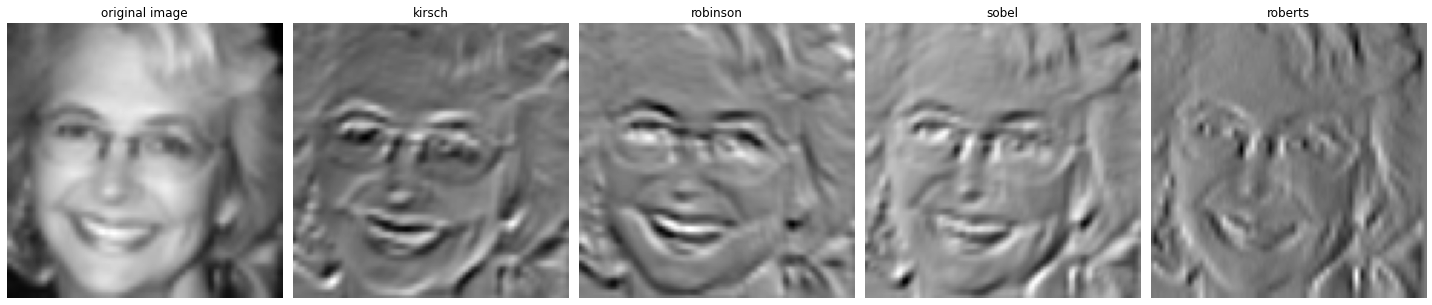

In [12]:
from scipy import ndimage


# img = images[random.randint(0, len(images)-1)]
img = images[0]



plt.figure(figsize=(20,20))

plt.subplot(1, 5, 1); plt.title('original image')
plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray')

img = img.squeeze(0)


kirsch_compass_masks = [
    np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]]),   # north
    np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]]),   # north-east
    np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]]),   # east
    np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]]),   # south-east
    # np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]]),   # south
    # np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]]),   # south-west 
    # np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]]),   # west
    # np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]]),   # north-west
]

robinson_compass_masks = [
    np.array([[-1,-0,1],[-2,0,2],[-1,0,1]]),   # north
    np.array([[0,1,2],[-1,0,1],[-2,-1,0]]),   # north-east
    np.array([[1,2,1],[0,0,0],[-1,-2,-1]]),   # east
    np.array([[2,1,0],[1,0,-1],[0,-1,-2]]),   # south-east
    # np.array([[0,1,2],[-1,0,-1],[-2,-1,0]]),   # south
    # np.array([[0,-1,-2],[1,0,-1],[2,1,0]]),   # south-west 
    # np.array([[2,1,0],[1,0,-1],[0,-1,-2]]),   # west
    # np.array([[-2,-1,0],[-1,0,1],[0,1,2]]),   # north-west
]

sobel_G_x = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]
sobel_G_y = [[1, 0, -1], [2, 0, -2], [1, 0, -1]]

roberts_G_x = [[1, 0], [0, -1]]
roberts_G_y = [[0, -1], [1, 0]]



kirsch = np.zeros_like(img)
for cm in kirsch_compass_masks:
    k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
    kirsch = np.add(kirsch, k)

plt.subplot(1, 5, 2); plt.title('kirsch')
plt.axis('off')
plt.imshow(kirsch, cmap='gray')


robinson = np.zeros_like(img)
for cm in robinson_compass_masks:
    k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
    robinson = np.add(robinson, k)
    
plt.subplot(1, 5, 3); plt.title('robinson')
plt.axis('off')
plt.imshow(robinson, cmap='gray')


sobel = ndimage.convolve(img, sobel_G_x) + ndimage.convolve(img, sobel_G_y)

plt.subplot(1, 5, 4); plt.title('sobel')
plt.axis('off')
plt.imshow(sobel, cmap='gray')


roberts = ndimage.convolve(img, roberts_G_x) + ndimage.convolve(img, roberts_G_y)

plt.subplot(1, 5, 5); plt.title('roberts')
plt.axis('off')
plt.imshow(roberts, cmap='gray')


plt.tight_layout(); plt.show()


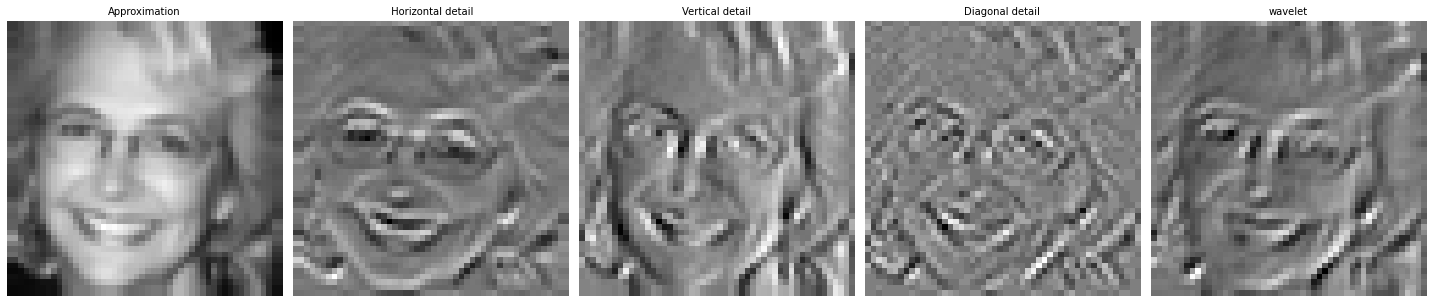

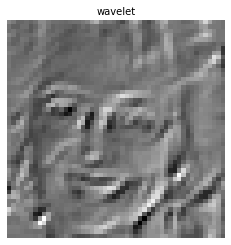

In [13]:
import pywt # pip install PyWavelets
import pywt.data


#img = images[random.randint(0, len(images)-1)]
img = images[0]

# img = pywt.data.camera()


titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(img, 'bior1.3')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(20, 20))

for i, a in enumerate([LL, LH, HL, HH]):
    plt.subplot(1, 5, i+1); 
    plt.imshow(np.transpose(a, (1,2,0)), interpolation="nearest", cmap='gray')
    plt.axis('off'); plt.title(titles[i], fontsize=10)


wavelet = LH + HL + HH

plt.subplot(1, 5, 5); 
plt.imshow(np.transpose(wavelet, (1,2,0)), cmap='gray')
plt.axis('off'); plt.title('wavelet', fontsize=10)

plt.tight_layout()
plt.show()



test = wavelet.copy()
test += 128
t = 30
test[test < t] = 0
test[test > 255-t] = 255

plt.imshow(np.transpose(test, (1,2,0)), cmap='gray')
plt.axis('off'); plt.title('wavelet', fontsize=10)
plt.show()